<a id='Top'></a>

# Multisurv model training<a class='tocSkip'></a>

Train MultiSurv models with different combinations of input data modalities.

In [1]:
!pip install tensorboard

In [1]:
%load_ext autoreload
%autoreload 2

%load_ext watermark

import sys
import os

import ipywidgets as widgets
import pandas as pd
import torch
import pynvml

if torch.cuda.is_available():
    print('>>> PyTorch detected CUDA <<<')

# Make modules in "src" dir visible
if os.getcwd() not in sys.path:
    sys.path.append(os.path.join(os.getcwd(), 'src'))

import utils
from model import Model

>>> PyTorch detected CUDA <<<


<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#DataLoader" data-toc-modified-id="DataLoader-1"><span class="toc-item-num">1&nbsp;&nbsp;</span><code>DataLoader</code></a></span></li><li><span><a href="#Model" data-toc-modified-id="Model-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Model</a></span><ul class="toc-item"><li><span><a href="#Different-intervals" data-toc-modified-id="Different-intervals-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Different intervals</a></span><ul class="toc-item"><li><span><a href="#Equidistant-times" data-toc-modified-id="Equidistant-times-2.1.1"><span class="toc-item-num">2.1.1&nbsp;&nbsp;</span>Equidistant times</a></span></li><li><span><a href="#By-duration-quantiles" data-toc-modified-id="By-duration-quantiles-2.1.2"><span class="toc-item-num">2.1.2&nbsp;&nbsp;</span>By duration quantiles</a></span></li></ul></li><li><span><a href="#Pick-learning-rate" data-toc-modified-id="Pick-learning-rate-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Pick learning rate</a></span></li><li><span><a href="#Fit" data-toc-modified-id="Fit-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Fit</a></span><ul class="toc-item"><li><span><a href="#Save-model-weights" data-toc-modified-id="Save-model-weights-2.3.1"><span class="toc-item-num">2.3.1&nbsp;&nbsp;</span>Save model weights</a></span></li></ul></li><li><span><a href="#Check-validation-metrics" data-toc-modified-id="Check-validation-metrics-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>Check validation metrics</a></span></li></ul></li></ul></div>

In [2]:
import torch
import subprocess

def check_gpu_setup():
    """Complete GPU detection and verification."""
    
    print("=== GPU DETECTION REPORT ===")
    
    # 1. Check CUDA availability
    print(f"CUDA available: {torch.cuda.is_available()}")
    print(f"CUDA version: {torch.version.cuda}")
    print(f"PyTorch version: {torch.__version__}")
    
    if not torch.cuda.is_available():
        print("❌ CUDA not available - will use CPU")
        return
    
    # 2. Check number of GPUs
    gpu_count = torch.cuda.device_count()
    print(f"Number of CUDA devices: {gpu_count}")
    
    # 3. List all available GPUs
    print("\n=== AVAILABLE GPUS ===")
    for i in range(gpu_count):
        props = torch.cuda.get_device_properties(i)
        print(f"GPU {i}: {props.name}")
        print(f"  Memory: {props.total_memory / 1024**3:.1f} GB")
        print(f"  Compute Capability: {props.major}.{props.minor}")
        print(f"  Multi Processors: {props.multi_processor_count}")
    
    # 4. Check current device
    current_device = torch.cuda.current_device()
    current_name = torch.cuda.get_device_name(current_device)
    print(f"\n=== CURRENT SELECTION ===")
    print(f"Current CUDA device: {current_device}")
    print(f"Current GPU name: {current_name}")
    
    # 5. Memory usage
    if torch.cuda.is_available():
        print(f"\n=== MEMORY USAGE ===")
        for i in range(gpu_count):
            allocated = torch.cuda.memory_allocated(i) / 1024**3
            reserved = torch.cuda.memory_reserved(i) / 1024**3
            total = torch.cuda.get_device_properties(i).total_memory / 1024**3
            print(f"GPU {i} ({torch.cuda.get_device_name(i)}):")
            print(f"  Allocated: {allocated:.2f} GB")
            print(f"  Reserved: {reserved:.2f} GB")
            print(f"  Total: {total:.1f} GB")
    
    # 6. Test tensor creation on GPU
    print(f"\n=== GPU FUNCTIONALITY TEST ===")
    try:
        # Create test tensor on GPU
        test_tensor = torch.randn(1000, 1000).cuda()
        result = torch.mm(test_tensor, test_tensor)
        print(f"✅ GPU computation successful")
        print(f"Test tensor device: {test_tensor.device}")
        print(f"Result tensor device: {result.device}")
        
        # Cleanup
        del test_tensor, result
        torch.cuda.empty_cache()
        
    except Exception as e:
        print(f"❌ GPU computation failed: {e}")

def check_nvidia_system():
    """Check NVIDIA system information."""
    print("\n=== NVIDIA SYSTEM INFO ===")
    
    try:
        # Run nvidia-smi command
        result = subprocess.run(['nvidia-smi'], capture_output=True, text=True)
        if result.returncode == 0:
            print("NVIDIA-SMI Output:")
            print(result.stdout)
        else:
            print("❌ nvidia-smi command failed")
            print(result.stderr)
    except FileNotFoundError:
        print("❌ nvidia-smi not found - NVIDIA drivers may not be installed")
    except Exception as e:
        print(f"❌ Error running nvidia-smi: {e}")

def set_gpu_preference():
    """Set GPU preference if multiple GPUs available."""
    
    if not torch.cuda.is_available():
        print("No CUDA GPUs available")
        return None
    
    gpu_count = torch.cuda.device_count()
    
    if gpu_count == 1:
        device = torch.device('cuda:0')
        print(f"✅ Using single GPU: {torch.cuda.get_device_name(0)}")
        return device
    
    print(f"\n=== MULTIPLE GPUS DETECTED ({gpu_count}) ===")
    
    # Show GPU options
    for i in range(gpu_count):
        props = torch.cuda.get_device_properties(i)
        print(f"GPU {i}: {props.name} ({props.total_memory / 1024**3:.1f} GB)")
    
    # Find the most powerful GPU (by memory)
    best_gpu = 0
    best_memory = 0
    
    for i in range(gpu_count):
        memory = torch.cuda.get_device_properties(i).total_memory
        if memory > best_memory:
            best_memory = memory
            best_gpu = i
    
    device = torch.device(f'cuda:{best_gpu}')
    print(f"✅ Auto-selected most powerful GPU: {torch.cuda.get_device_name(best_gpu)}")
    
    # Set as current device
    torch.cuda.set_device(best_gpu)
    
    return device

def verify_pytorch_gpu_usage():
    """Verify PyTorch is actually using the NVIDIA GPU (not Intel)."""
    
    print("\n=== PYTORCH GPU VERIFICATION ===")
    
    if not torch.cuda.is_available():
        print("❌ PyTorch not using GPU - will use CPU")
        return False
    
    # Create tensor and check device
    x = torch.randn(100, 100).cuda()
    gpu_name = torch.cuda.get_device_name(x.device)
    
    print(f"✅ PyTorch using: {gpu_name}")
    
    # Check if it's NVIDIA (not Intel)
    if 'nvidia' in gpu_name.lower() or 'geforce' in gpu_name.lower() or 'rtx' in gpu_name.lower() or 'gtx' in gpu_name.lower():
        print(f"✅ Confirmed: Using NVIDIA GPU")
        return True
    elif 'intel' in gpu_name.lower():
        print(f"⚠️  Warning: Using Intel GPU - this may be slow for deep learning")
        return False
    else:
        print(f"❓ Unknown GPU type: {gpu_name}")
        return True

# Run all checks
def complete_gpu_check():
    """Run complete GPU diagnostic."""
    check_gpu_setup()
    check_nvidia_system()
    device = set_gpu_preference()
    is_nvidia = verify_pytorch_gpu_usage()
    
    print(f"\n=== RECOMMENDATION ===")
    if is_nvidia and device:
        print(f"✅ Ready for GPU training with device: {device}")
        print(f"Use: multisurv.device = {device}")
    else:
        print("⚠️  Consider using CPU training: multisurv.device = torch.device('cpu')")
    
    return device

# Quick check function
def quick_gpu_check():
    """Quick GPU check for immediate feedback."""
    if torch.cuda.is_available():
        gpu_name = torch.cuda.get_device_name(0)
        print(f"🎯 PyTorch is using: {gpu_name}")
        
        if any(keyword in gpu_name.lower() for keyword in ['nvidia', 'geforce', 'rtx', 'gtx']):
            print("✅ NVIDIA GPU detected - good for training!")
        else:
            print("⚠️  Non-NVIDIA GPU detected")
    else:
        print("❌ No GPU available - will use CPU")

# Run the checks
quick_gpu_check()
print("\n" + "="*50)
complete_gpu_check()

🎯 PyTorch is using: NVIDIA GeForce RTX 4060 Laptop GPU
✅ NVIDIA GPU detected - good for training!

=== GPU DETECTION REPORT ===
CUDA available: True
CUDA version: 11.8
PyTorch version: 2.4.0
Number of CUDA devices: 1

=== AVAILABLE GPUS ===
GPU 0: NVIDIA GeForce RTX 4060 Laptop GPU
  Memory: 8.0 GB
  Compute Capability: 8.9
  Multi Processors: 24

=== CURRENT SELECTION ===
Current CUDA device: 0
Current GPU name: NVIDIA GeForce RTX 4060 Laptop GPU

=== MEMORY USAGE ===
GPU 0 (NVIDIA GeForce RTX 4060 Laptop GPU):
  Allocated: 0.00 GB
  Reserved: 0.00 GB
  Total: 8.0 GB

=== GPU FUNCTIONALITY TEST ===
✅ GPU computation successful
Test tensor device: cuda:0
Result tensor device: cuda:0

=== NVIDIA SYSTEM INFO ===
NVIDIA-SMI Output:
Thu Jun 19 12:00:38 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 575.64.01              Driver Version: 576.80         CUDA Version: 12.9     |
|-----------------------------------------+--

device(type='cuda', index=0)

In [58]:
DATA = utils.INPUT_DATA_DIR
MODELS = utils.TRAINED_MODEL_DIR

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# `DataLoader`

In [59]:
data_modalities = widgets.SelectMultiple(
    options=['clinical', 'mRNA', 'DNAm', 'miRNA', 'CNV', 'wsi'],
    index=[0, 1],
    rows=6,
    description='Input data',
    disabled=False
)
display(data_modalities)

SelectMultiple(description='Input data', index=(0, 1), options=('clinical', 'mRNA', 'DNAm', 'miRNA', 'CNV', 'w…

In [60]:
#-----------------------------------------------------------------------------#
#                             20-CANCER SUBSET                                #
#                 (to compare to Cheerla and Gevaert 2019)                    #
#-----------------------------------------------------------------------------#

cancers = ['BRCA']

labels = pd.read_csv('/app/data/labels.tsv', sep='\t')
print(labels.head(3))


   submitter_id      time  event  group
0  TCGA-Z7-A8R6  8.920548      0  train
1  TCGA-C8-A1HE  1.027397      0  train
2  TCGA-A8-A07B  3.583562      0  train


In [61]:
dataloaders = utils.get_dataloaders(data_location=DATA,
                                    labels_file='/app/data/labels.tsv',
                                    modalities=data_modalities.value,
                                    wsi_patch_size=299,
                                    n_wsi_patches=5,
#                                     batch_size=20,
#                                    batch_size=64,
                                     batch_size=32,
                                   )

Data modalities:
   clinical

Dataset sizes (# patients):
   train: 876
   val: 110
   test: 108

Batch size: 32


# Model

## Different intervals

If trying out different time interval outputs.

### Equidistant times

In [7]:
interval_cuts = torch.arange(0., 365 * 5.1, 365 / 2)

### By duration quantiles

In [62]:
labels = [(t, e) for t, e in dataloaders['train'].dataset.label_map.values()]
durations = [t for t, _ in labels]
events = [e for _, e in labels]

interval_cuts = utils.discretize_time_by_duration_quantiles(durations, events, 20)
interval_cuts = torch.from_numpy(interval_cuts)

In [63]:

multisurv = Model(
    dataloaders=dataloaders,
    auxiliary_criterion=None,  # No auxiliary loss needed
    output_intervals=interval_cuts,
    device=device
)

Instantiating MultiSurv model...


/app/src/multisurv.py:84: UserWarning: Input data is unimodal: no fusion procedure.
  warnings.warn('Input data is unimodal: no fusion procedure.')


In [64]:
def create_gpu_enabled_multisurv():
    """Create a fresh MultiSurv instance with proper GPU setup."""
    
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    print(f"Creating MultiSurv with device: {device}")
    
    
    # Create new model with GPU device
    gpu_multisurv = Model(
        dataloaders=multisurv.dataloaders,  # Reuse existing dataloaders
        fusion_method=multisurv.fusion_method,
        output_intervals=multisurv.output_intervals.to(device),  # Move to GPU
        device=device  # Set device properly
    )
    
    print("✅ GPU-enabled MultiSurv created!")
    return gpu_multisurv

In [65]:
gpu_multisurv = create_gpu_enabled_multisurv()

Creating MultiSurv with device: cuda:0
Instantiating MultiSurv model...
✅ GPU-enabled MultiSurv created!


In [66]:
print('Output intervals (in years):')
gpu_multisurv.output_intervals / 365

Output intervals (in years):


tensor([ 0.0000,  1.5562,  2.4137,  3.0712,  4.0082,  4.6356,  5.2767,  6.4329,
         6.8904,  7.5589,  8.0904,  8.9342,  9.4685,  9.8822, 10.4301, 10.7562,
        11.9479, 19.5233, 23.5753], device='cuda:0', dtype=torch.float64)

In [67]:
gpu_multisurv.model_blocks

['clinical_submodel', 'fc_block', 'risk_layer']

In [68]:
print('Trainable blocks:')
layer = None

for name, child in gpu_multisurv.model.named_children():
    for name_2, params in child.named_parameters():
        if name is not layer:
            print(f'   {name}: {params.requires_grad}')
        layer = name

Trainable blocks:
   clinical_submodel: True
   fc_block: True
   risk_layer: True


In [69]:
gpu_multisurv.model

MultiSurv(
  (clinical_submodel): ClinicalNet(
    (embedding_layers): ModuleList(
      (0): Embedding(2, 1)
      (1): Embedding(7, 4)
      (2-4): 3 x Embedding(3, 2)
      (5-6): 2 x Embedding(4, 2)
    )
    (embedding_dropout): Dropout(p=0.5, inplace=False)
    (bn_layer): BatchNorm1d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (linear): Linear(in_features=16, out_features=256, bias=True)
    (output_layer): FC(
      (fc): Sequential(
        (0): Dropout(p=0.5, inplace=False)
        (1): Linear(in_features=256, out_features=512, bias=True)
        (2): ReLU()
      )
    )
  )
  (fc_block): FC(
    (fc): Sequential(
      (0): Dropout(p=0.5, inplace=False)
      (1): Linear(in_features=512, out_features=2048, bias=True)
      (2): ReLU()
      (3): BatchNorm1d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (4): Dropout(p=0.5, inplace=False)
      (5): Linear(in_features=2048, out_features=2048, bias=True)
      (6): ReLU(

## Pick learning rate

In [70]:
# Check GPU usage after LR test
def monitor_gpu_real_time():
    import torch
    allocated = torch.cuda.memory_allocated(0) / 1024**3
    reserved = torch.cuda.memory_reserved(0) / 1024**3
    print(f"🎯 GPU Memory: {allocated:.2f} GB allocated, {reserved:.2f} GB reserved")
    
    # Check if there are any tensors on GPU
    print(f"🔍 GPU cache size: {torch.cuda.memory_cached(0) / 1024**3:.2f} GB")
monitor_gpu_real_time()

🎯 GPU Memory: 1.58 GB allocated, 1.69 GB reserved
🔍 GPU cache size: 1.69 GB


/tmp/ipykernel_28/1937229576.py:9: FutureWarning: `torch.cuda.memory_cached` has been renamed to `torch.cuda.memory_reserved`
  print(f"🔍 GPU cache size: {torch.cuda.memory_cached(0) / 1024**3:.2f} GB")


In [71]:
data_example, _, _ = dataloaders['train'].dataset[0]
print("Categorical features:\n", data_example['clinical'][0])
print("Continuous features:\n", data_example['clinical'][1])


Categorical features:
 tensor([0., 6., 0., 1., 0., 1., 1.])
Continuous features:
 tensor([0.5868])


In [72]:
# GPU-compatible version of the completely fixed LR test

def gpu_fixed_lr_test_run(self, init_value=1e-8, final_value=10., beta=0.98):
    """GPU-compatible LR test that ensures all tensors are on the same device."""
    print(">>> Using GPU-COMPATIBLE FIXED lr_test.run method")
    
    power = (1 / (len(self.dataloader) - 1))
    mult = (final_value / init_value) ** power
    lr = init_value
    self.optimizer.param_groups[0]['lr'] = lr
    avg_loss = 0.
    best_loss = 0.
    batch_num = 0

    print('>>> Compute loss at increasing LR values')
    
    # Clear losses and lrs lists
    self.losses = []
    self.lrs = []

    for data in self.dataloader:
        batch_num += 1
        print('\r' + f'    Iterate over mini-batches: {str(batch_num)}', end='')

        try:
            # Unpack data
            if len(data) == 3:
                modality_data, time, event = data
            elif len(data) == 4:
                modality_data, time, event, pid = data
            
            # CRITICAL: Move ALL data to the same device as the model
            target_device = next(self.model.parameters()).device
            
            # Move modality data to device
            for key, value in modality_data.items():
                if isinstance(value, torch.Tensor):
                    modality_data[key] = value.to(target_device)
                elif isinstance(value, (list, tuple)):
                    modality_data[key] = tuple(v.to(target_device) if isinstance(v, torch.Tensor) else v for v in value)
            
            # Move time and event to device
            time = time.to(target_device)
            event = event.to(target_device)
            
            # Set model to train mode
            self.model.train()
            
            # Clear gradients
            self.optimizer.zero_grad()
            
            # Forward pass
            with torch.set_grad_enabled(True):
                feature_representations, risk = self.model(modality_data)
                modality_features = feature_representations['modalities']
                
                # Compute loss with proper device handling
                try:
                    # Ensure output_intervals are on the same device
                    if hasattr(self, 'output_intervals'):
                        breaks = self.output_intervals.to(target_device)
                    else:
                        breaks = torch.linspace(0, 10, 19, device=target_device)  # Fallback
                    
                    loss = self.criterion(risk, times=time, events=event, breaks=breaks, device=target_device)
                    
                except Exception as loss_error:
                    print(f"\nPrimary criterion failed: {loss_error}")
                    # Fallback to simple MSE loss on the same device
                    dummy_target = torch.ones_like(risk)  # This will be on the same device as risk
                    loss = torch.nn.functional.mse_loss(risk, dummy_target)
                    print("Using fallback MSE loss")
                
                # Add auxiliary loss if needed
                if self.aux_criterion is not None:
                    try:
                        if len(modality_features) >= 2:
                            target = torch.ones(modality_features[0].shape[0], device=target_device)
                            aux_loss = self.aux_criterion(modality_features[0], modality_features[1], target)
                            loss = loss + 0.1 * aux_loss
                    except Exception as aux_error:
                        print(f"\nAuxiliary criterion failed: {aux_error}")
            
            # Store the loss value
            loss_value = loss.item()
            
        except Exception as e:
            print(f"\nError at batch {batch_num}: {e}")
            break

        # Compute the smoothed loss
        avg_loss = (beta * avg_loss + (1 - beta) * loss_value)
        smoothed_loss = avg_loss / (1 - beta ** batch_num)

        # Stop if the loss is exploding
        if batch_num > 1 and smoothed_loss > 4 * best_loss:
            print()
            print('    Exploding loss; finish test.')
            break

        # Record the best loss
        if smoothed_loss < best_loss or batch_num == 1:
            best_loss = smoothed_loss
            
        # Store the values
        self.losses.append(smoothed_loss)
        self.lrs.append(lr)

        # Do the backward pass and optimizer step
        try:
            loss.backward(retain_graph=False)
            self.optimizer.step()
        except Exception as e:
            print(f"\nBackward pass failed at batch {batch_num}: {e}")
            break

        # Update the lr for the next step
        lr *= mult
        self.optimizer.param_groups[0]['lr'] = lr
        
        # Stop after reasonable number of batches
        if batch_num >= 100:
            print("\nStopping after 100 batches")
            break

    print()
    print('    Completed test.')
    return self

# Apply the GPU-compatible fix
import lr_range_test
lr_range_test.LRRangeTest.run = gpu_fixed_lr_test_run
print("Applied GPU-compatible fix to LRRangeTest.run")

Applied GPU-compatible fix to LRRangeTest.run


In [73]:
%%time

torch.autograd.set_detect_anomaly(False)  # Disable anomaly detection too
gpu_multisurv.test_lr_range()  # Use the new GPU instance

>>> Using GPU-COMPATIBLE FIXED lr_test.run method
>>> Compute loss at increasing LR values
    Iterate over mini-batches: 27
    Completed test.
CPU times: user 632 ms, sys: 93.2 ms, total: 725 ms
Wall time: 2.6 s


Number of loss values collected: 27
Number of learning rates tested: 27
LR range: 1.00e-06 to 1.00e+01
Loss range: 0.056017 to 0.070558


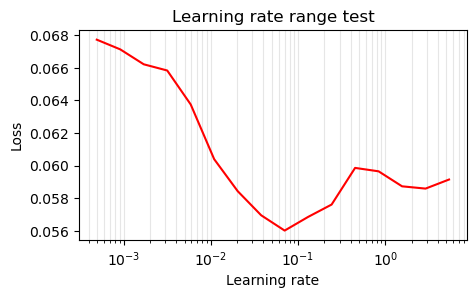

In [74]:
# Check the results
print(f"Number of loss values collected: {len(gpu_multisurv.lr_test.losses)}")
print(f"Number of learning rates tested: {len(gpu_multisurv.lr_test.lrs)}")
print(f"LR range: {min(gpu_multisurv.lr_test.lrs):.2e} to {max(gpu_multisurv.lr_test.lrs):.2e}")
print(f"Loss range: {min(gpu_multisurv.lr_test.losses):.6f} to {max(gpu_multisurv.lr_test.losses):.6f}")

# Plot the results to find optimal learning rate
gpu_multisurv.plot_lr_range(trim=1)

## Fit

In [75]:
# GPU-compatible fix for _predictions_to_pycox method
def gpu_fixed_predictions_to_pycox(self, preds, time_points=None):
    """GPU-compatible version that properly handles device transfers."""
    import pandas as pd
    import torch
    
    # preds shape is [num_patients, num_intervals] e.g., [864, 18]
    # Convert predictions to DataFrame (move to CPU first)
    df = pd.DataFrame(preds.detach().cpu().numpy())  # Added .detach() for GPU tensors
    
    if time_points is None:
        # Get the number of intervals from the model output
        n_intervals = preds.shape[1]  # Should be 18 for your model
        
        # Use the model's actual output intervals
        if hasattr(self, 'output_intervals') and self.output_intervals is not None:
            # Handle GPU tensors properly
            intervals = self.output_intervals
            if torch.is_tensor(intervals):
                intervals = intervals.detach().cpu()  # Move to CPU for calculations
            
            if len(intervals) > n_intervals:
                # Take the first n_intervals midpoints
                midpoints = (intervals[:-1] + intervals[1:]) / 2
                time_points = midpoints[:n_intervals]
            else:
                # Fallback to evenly spaced points
                last_interval = intervals[-1].item() if torch.is_tensor(intervals) else intervals[-1]
                time_points = torch.linspace(0.5, last_interval / 365, n_intervals)
        else:
            # Fallback: create time points that match the output size
            time_points = torch.arange(0.5, 0.5 + n_intervals, 1.0)
    
    # Ensure time_points matches the prediction dimensions
    if len(time_points) != preds.shape[1]:
        print(f"Warning: Adjusting time_points from {len(time_points)} to {preds.shape[1]}")
        first_point = time_points[0].item() if torch.is_tensor(time_points) else time_points[0]
        last_point = time_points[-1].item() if torch.is_tensor(time_points) else time_points[-1]
        time_points = torch.linspace(first_point, last_point, preds.shape[1])
    
    # FIXED: The DataFrame structure should be transposed
    # We want columns to be time points, rows to be patients
    df = df.T  # Transpose so shape becomes [num_intervals, num_patients]
    
    # Convert time_points to numpy if it's a tensor (ensure CPU)
    if torch.is_tensor(time_points):
        time_points = time_points.detach().cpu().numpy()
    
    # Set the index to time points
    df.index = time_points
    df.index.name = 'time'
    
    return df

# Apply the GPU-compatible fix to ModelCoach
from coach import ModelCoach
ModelCoach._predictions_to_pycox = gpu_fixed_predictions_to_pycox
print("✅ Applied GPU-compatible fix to ModelCoach._predictions_to_pycox method")

# Debug info with GPU handling
print(f"Model output intervals shape: {len(gpu_multisurv.output_intervals)}")
print(f"Model output intervals device: {gpu_multisurv.output_intervals.device}")
print(f"Model risk layer output: {gpu_multisurv.model.risk_layer[0].out_features}")
print(f"Expected: {len(gpu_multisurv.output_intervals) - 1} intervals for {len(gpu_multisurv.output_intervals)} breakpoints")

✅ Applied GPU-compatible fix to ModelCoach._predictions_to_pycox method
Model output intervals shape: 19
Model output intervals device: cuda:0
Model risk layer output: 18
Expected: 18 intervals for 19 breakpoints


In [76]:
# Cell 1: Setup with GPU verification
import os
import time
import utils
import torch
from datetime import datetime

# 1. Record start time
start_time = time.time()

# 2. Verify GPU setup before training
print("=== PRE-TRAINING GPU VERIFICATION ===")
print(f"GPU model device: {next(gpu_multisurv.model.parameters()).device}")
print(f"GPU intervals device: {gpu_multisurv.output_intervals.device}")
print(f"GPU device setting: {gpu_multisurv.device}")

# Check GPU memory
if torch.cuda.is_available():
    allocated = torch.cuda.memory_allocated(0) / 1024**3
    print(f"GPU memory before training: {allocated:.2f} GB")

# 3. Set up training parameters
picked_lr = 1e-3

# Add timestamp to make unique run tags
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

run_tag = utils.compose_run_tag(
    model=gpu_multisurv, 
    lr=picked_lr,
    dataloaders=gpu_multisurv.dataloaders,
    log_dir='./training_logs/',
    suffix=f'_breast_cancer_gpu_{timestamp}'  # Added 'gpu' to indicate GPU training
)

# 4. Create log directory
log_dir = os.path.join('./training_logs/', run_tag)
os.makedirs(log_dir, exist_ok=True)
print(f"✅ Log directory created: {log_dir}")

print("✅ Setup complete - ready for GPU training!")

=== PRE-TRAINING GPU VERIFICATION ===
GPU model device: cuda:0
GPU intervals device: cuda:0
GPU device setting: cuda:0
GPU memory before training: 1.70 GB
Run tag: "clinical_lr0.001_breast_cancer_gpu_20250619_161729"
✅ Log directory created: ./training_logs/clinical_lr0.001_breast_cancer_gpu_20250619_161729
✅ Setup complete - ready for GPU training!


In [77]:
# Cell 2: Training execution with GPU monitoring
fit_args = {
    'lr': picked_lr,
    'num_epochs': 100,
    'info_freq': 5,
    'lr_factor': 0.5,
    'scheduler_patience': 15,
    'log_dir': log_dir,
}

print(f"🚀 Starting GPU training with LR: {picked_lr}")
print(f"📊 Expected to see GPU utilization spike during training")
print(f"📁 Logs will be saved to: {log_dir}")

# Function to monitor GPU during training
def check_gpu_status():
    if torch.cuda.is_available():
        allocated = torch.cuda.memory_allocated(0) / 1024**3
        reserved = torch.cuda.memory_reserved(0) / 1024**3
        print(f"🎯 GPU Memory: {allocated:.2f} GB allocated, {reserved:.2f} GB reserved")
    else:
        print("❌ CUDA not available")

# Check GPU before training
print("\n=== GPU STATUS BEFORE TRAINING ===")
check_gpu_status()

# Clear any cached memory
torch.cuda.empty_cache()

# Start training
print(f"\n⏰ Training started at: {datetime.now().strftime('%H:%M:%S')}")

try:
    # This is where the actual training happens
    gpu_multisurv.fit(**fit_args)
    
    print(f"\n✅ Training completed successfully!")
    
except Exception as e:
    print(f"\n❌ Training failed with error: {e}")
    print("This might be due to GPU memory issues or device mismatches")
    # Print more debug info
    print(f"Model device: {next(gpu_multisurv.model.parameters()).device}")
    import traceback
    traceback.print_exc()

# Check GPU after training
print("\n=== GPU STATUS AFTER TRAINING ===")
check_gpu_status()

# Calculate and display elapsed time
hrs, mins, secs = utils.elapsed_time(start_time)
print(f"\n⏰ Training completed in {hrs}h {mins}m {secs}s")
print(f"🏁 Training finished at: {datetime.now().strftime('%H:%M:%S')}")


🚀 Starting GPU training with LR: 0.001
📊 Expected to see GPU utilization spike during training
📁 Logs will be saved to: ./training_logs/clinical_lr0.001_breast_cancer_gpu_20250619_161729

=== GPU STATUS BEFORE TRAINING ===
🎯 GPU Memory: 1.70 GB allocated, 1.76 GB reserved

⏰ Training started at: 16:17:37
Instantiating MultiSurv model...

------------------------------------------
             Training        Validation
           ------------     ------------
 Epoch     Loss     Ctd     Loss     Ctd
------------------------------------------


/opt/conda/envs/multisurv/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


 1/100    0.0278   0.558   0.0178   0.746
 5/100    0.0189   0.661   0.0190   0.610
 10/100   0.0177   0.625   0.0202   0.582
 15/100   0.0179   0.576   0.0154   0.657
 20/100   0.0173   0.620   0.0156   0.568
 25/100   0.0158   0.625   0.0150   0.751
 30/100   0.0154   0.672   0.0156   0.582
 35/100   0.0153   0.666   0.0179   0.437
 40/100   0.0149   0.692   0.0162   0.596
 45/100   0.0150   0.647   0.0156   0.601
 50/100   0.0145   0.658   0.0176   0.493
 55/100   0.0146   0.695   0.0182   0.465
 60/100   0.0139   0.679   0.0180   0.446
 65/100   0.0134   0.691   0.0169   0.502
 70/100   0.0137   0.683   0.0173   0.484
 75/100   0.0138   0.695   0.0175   0.465
 80/100   0.0135   0.707   0.0180   0.469
 85/100   0.0137   0.688   0.0176   0.474
 90/100   0.0133   0.666   0.0177   0.488
 95/100   0.0135   0.660   0.0178   0.479
 100/100  0.0138   0.691   0.0178   0.479

>>>>> Training completed in 5m 35s
>>>>> Best validation C-indices:
     0.7230046948356808 (epoch16)
     0.77934272

### Save model weights

If desired.

In [78]:
gpu_multisurv.best_model_weights.keys()

dict_keys(['epoch16', 'epoch24', 'epoch25'])

In [79]:
gpu_multisurv.best_concord_values

{'epoch16': 0.7230046948356808,
 'epoch24': 0.7793427230046949,
 'epoch25': 0.7511737089201878}

In [80]:
gpu_multisurv.current_concord

{'epoch100': 0.4788732394366197}

In [81]:
gpu_multisurv.save_weights(saved_epoch='epoch24', prefix=run_tag, weight_dir=MODELS)

Saving model weights to file:
    /mnt/data/multisurv_models/clinical_lr0.001_breast_cancer_gpu_20250619_161729_epoch24_concord0.78.pth


## Check validation metrics

In [12]:
dataloaders = utils.get_dataloaders(data_location=DATA,
                                    labels_file='data/labels.tsv',
                                    modalities=data_modalities.value,
                                    wsi_patch_size=299,
                                    n_wsi_patches=5,
#                                     exclude_patients=exclude_cancers,
                                    
                                    return_patient_id=True,
                                   )

Data modalities:
   clinical
   mRNA

Dataset sizes (# patients):
   train: 876
   val: 110
   test: 108

Batch size: 128


In [82]:
# Fix for evaluation.py _predictions_to_pycox method

def fixed_evaluation_predictions_to_pycox(self, data, time_points=None):
    """Fixed evaluation version that handles the correct dimensions."""
    import pandas as pd
    import torch
    import numpy as np
    
    # Extract predictions from data
    # data should be a list of tuples: (predictions, times, events, patient_ids)
    predictions_list = []
    for item in data:
        pred = item[0]  # The prediction tensor
        if torch.is_tensor(pred):
            pred = pred.detach().cpu().numpy()
        predictions_list.append(pred)
    
    # Convert to numpy array
    predictions = np.array(predictions_list)
    
    # Create DataFrame
    df = pd.DataFrame(predictions)
    
    if time_points is None:
        # Get the number of intervals from the model output
        n_intervals = predictions.shape[1]  # Should be 18 for your model
        
        # Use the model's actual output intervals if available
        if hasattr(self, 'model') and hasattr(self.model, 'output_intervals') and self.model.output_intervals is not None:
            # Use the midpoints of the output intervals
            intervals = self.model.output_intervals
            if torch.is_tensor(intervals):
                intervals = intervals.detach().cpu().numpy()
            
            if len(intervals) > n_intervals:
                # Take the first n_intervals midpoints
                midpoints = (intervals[:-1] + intervals[1:]) / 2
                time_points = midpoints[:n_intervals]
            else:
                # Fallback to evenly spaced points
                last_interval = intervals[-1] if not torch.is_tensor(intervals) else intervals[-1].item()
                time_points = np.linspace(0.5, last_interval / 365, n_intervals)
        else:
            # Fallback: create time points that match the output size
            time_points = np.arange(0.5, 0.5 + n_intervals, 1.0)
    
    # Ensure time_points matches the prediction dimensions
    if len(time_points) != predictions.shape[1]:
        print(f"Warning: Adjusting time_points from {len(time_points)} to {predictions.shape[1]}")
        first_point = time_points[0] if len(time_points) > 0 else 0.5
        last_point = time_points[-1] if len(time_points) > 0 else n_intervals + 0.5
        time_points = np.linspace(first_point, last_point, predictions.shape[1])
    
    # FIXED: The DataFrame structure should be transposed
    # We want columns to be time points, rows to be patients
    df = df.T  # Transpose so shape becomes [num_intervals, num_patients]
    
    # Convert time_points to numpy if it's a tensor
    if torch.is_tensor(time_points):
        time_points = time_points.detach().cpu().numpy()
    
    # Set the index to time points
    df.index = time_points
    df.index.name = 'time'
    
    return df

# Apply the fix to the evaluation module
import evaluation

# Check if the _BaseEvaluation class exists and patch it
if hasattr(evaluation, '_BaseEvaluation'):
    evaluation._BaseEvaluation._predictions_to_pycox = fixed_evaluation_predictions_to_pycox
    print("✅ Applied fix to _BaseEvaluation._predictions_to_pycox")
else:
    print("❌ _BaseEvaluation class not found")

# Also check for Evaluation class
if hasattr(evaluation, 'Evaluation'):
    evaluation.Evaluation._predictions_to_pycox = fixed_evaluation_predictions_to_pycox
    print("✅ Applied fix to Evaluation._predictions_to_pycox")

# Fix the syntax warning too
def patch_syntax_warning():
    """Fix the syntax warning in evaluation.py if possible."""
    print("💡 Note: There's a syntax warning in evaluation.py line 187")
    print("   Change 'self.type is not 'MultiSurv'' to 'self.type != 'MultiSurv''")
    print("   This doesn't affect functionality but should be fixed in the source code")

patch_syntax_warning()

print("\n🔧 Evaluation fixes applied! Now try running your evaluation again.")

✅ Applied fix to _BaseEvaluation._predictions_to_pycox
✅ Applied fix to Evaluation._predictions_to_pycox
💡 Note: There's a syntax warning in evaluation.py line 187
   Change 'self.type is not 'MultiSurv'' to 'self.type != 'MultiSurv''
   This doesn't affect functionality but should be fixed in the source code

🔧 Evaluation fixes applied! Now try running your evaluation again.


In [83]:
performance = utils.Evaluation(
    model=gpu_multisurv, dataset=dataloaders['val'].dataset,
    device=device)
performance.compute_metrics()
performance.show_results()

Collect patient predictions: 110/110

C-index   0.809
Ctd       0.842
IBS       0.107
INBLL     0.348


In [84]:
# Evaluate on TEST set (not validation)
performance = utils.Evaluation(
    model=gpu_multisurv, 
    dataset=dataloaders['test'].dataset,  # Note: 'test' not 'val'
    device=device
)
performance.compute_metrics()
print("TEST SET RESULTS:")
performance.show_results()

Collect patient predictions: 108/108

TEST SET RESULTS:
C-index   0.538
Ctd       0.485
IBS       0.173
INBLL     0.525


# Watermark <a class='tocSkip'></a>

In [ ]:
%watermark --iversions
%watermark -v
print()
%watermark -u -n

[Top of the page](#Top)